<a href="https://colab.research.google.com/github/RMoulla/Machine-learning/blob/main/TP_GNN_GAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TP : Réseaux de neurones graphiques à base d'Attention.

Dans ce TP, nous nous proposons d'étudier le dataset Cora. Celui-ci est composé de 2708 papiers scientifiques répartis en sept classes. L'objectif de ce TP est de construire un modèle permettant de prédire la classe à laquelle appartient un noeud (papier scientifique).



In [1]:
import os
import torch
import networkx as nx
import pandas as pd
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.1.1+cu121


In [2]:
from torch_geometric.data import Data
from torch_geometric.nn import GATConv
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
import torch_geometric.transforms as T

import matplotlib.pyplot as plt
import networkx as nx

## Analyse du dataset Cora

On se propose ici d'explorer le dataset Cora. Il est fortement recommandé de compléter cette analyse exploratoire (visualiser le graphe, etc.).

In [3]:

dataset = Planetoid(root='~/somewhere/Cora', name='Cora')

data = dataset[0]
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')

Dataset: Cora():
Number of graphs: 1
Number of features: 1433
Number of classes: 7
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Number of training nodes: 140
Training node label rate: 0.05
Contains isolated nodes: False
Contains self-loops: False


/home/yasser_wsl/miniconda3/envs/tp/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/home/yasser_wsl/miniconda3/envs/tp/lib/python3.9/site-packages/torch_geometric/deprecation.py:22: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


In [4]:
# Création d'un graphe NetworkX à partir des données PyTorch Geometric
G = nx.Graph()

# Ajout des arêtes du graphe
edge_index = data.edge_index.numpy()
edges = [(edge_index[0, i], edge_index[1, i]) for i in range(edge_index.shape[1])]
G.add_edges_from(edges)

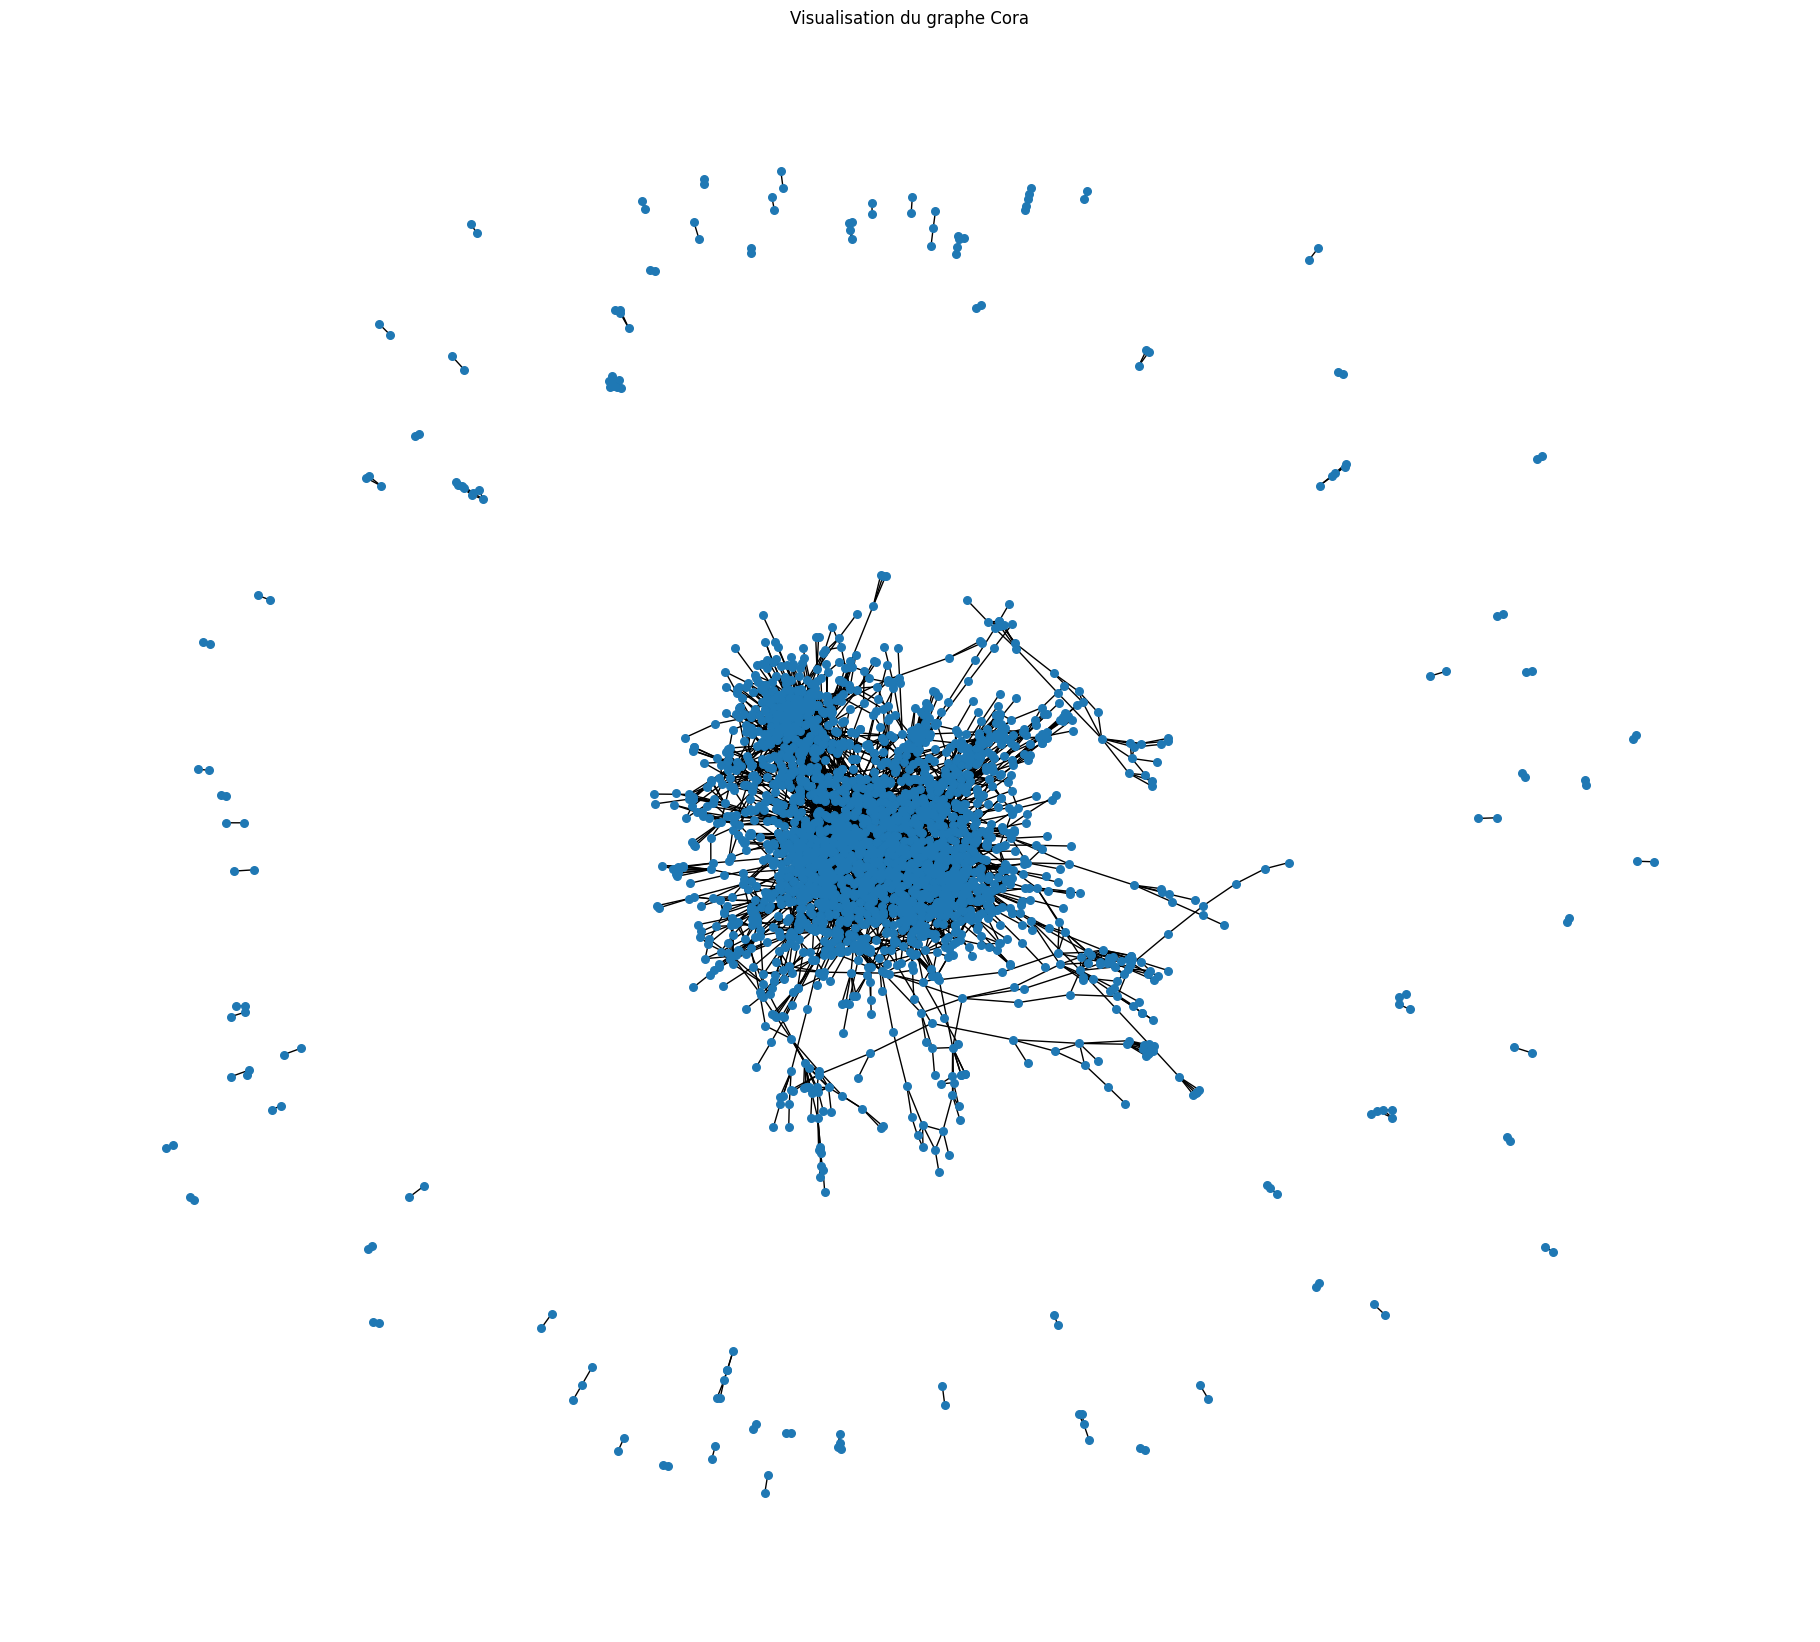

In [5]:
# Visualisation du graphe avec NetworkX
plt.figure(figsize=(18, 16))
nx.draw(G, with_labels=False, node_size=30)
plt.title('Visualisation du graphe Cora')
plt.show()

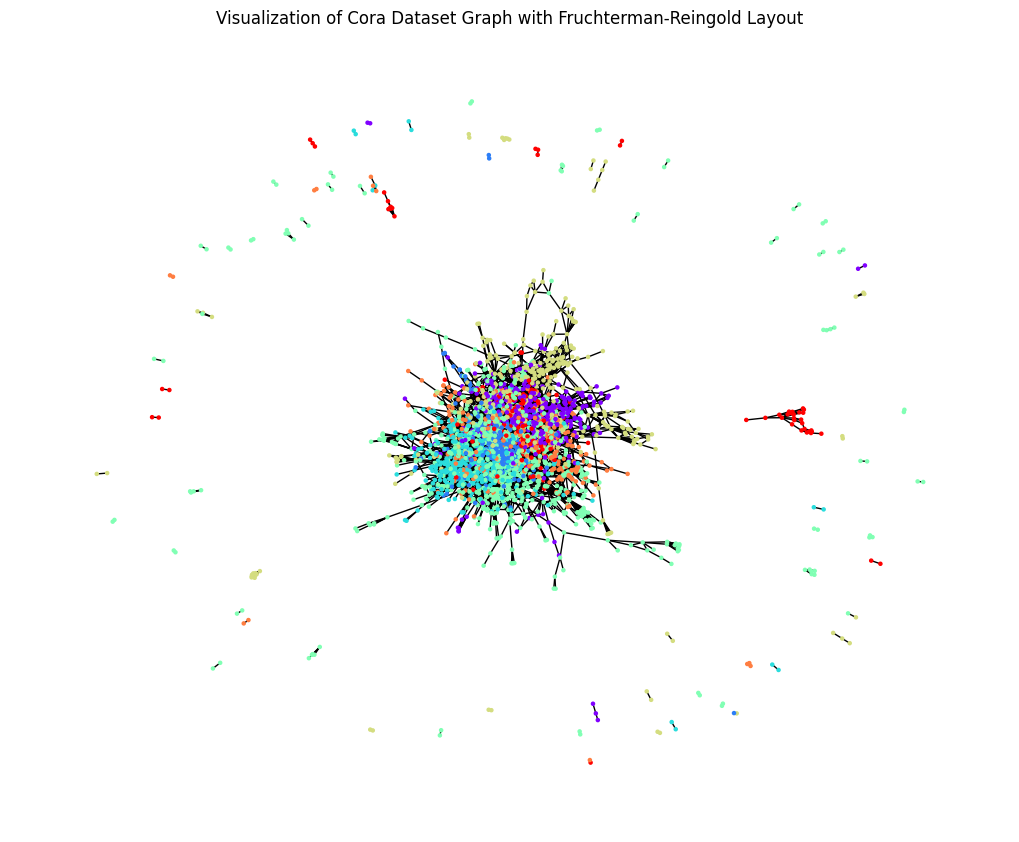

In [6]:
# Convertir les données PyG en graphe NetworkX
G = to_networkx(data, to_undirected=True)

# Utiliser la disposition Fruchterman-Reingold
pos = nx.fruchterman_reingold_layout(G)

# Obtenir les classes des nœuds
node_classes = data.y.numpy()

# Visualiser le graphe avec coloration des nœuds en fonction des classes
plt.figure(figsize=(10, 8))
nx.draw(G, pos, with_labels=False, node_size=5, node_color=node_classes, cmap=plt.cm.rainbow)
plt.title('Visualization of Cora Dataset Graph with Fruchterman-Reingold Layout')
plt.show()

## Question 1 : construire un modèle à base de GAT qui permet de prédire la classe à laquelle appartient un noeud.
---



In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GATConv

# Charger le jeu de données Cora
dataset = Planetoid(root='~/somewhere/Cora', name='Cora')
data = dataset[0]

# Définir un modèle de GAT
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super(GAT, self).__init__()
        # Première couche de convolution GAT
        self.conv1 = GATConv(in_channels, hidden_channels, heads=8)
        # Deuxième couche de convolution GAT
        self.conv2 = GATConv(hidden_channels * 8, out_channels, heads=1)

    def forward(self, x, edge_index):
        # Appliquer une couche de dropout
        x = F.dropout(x, p=0.6, training=self.training)
        # Appliquer la fonction d'activation ELU à la première couche de convolution GAT
        x = F.elu(self.conv1(x, edge_index))
        # Appliquer une nouvelle couche de dropout
        x = F.dropout(x, p=0.6, training=self.training)
        # Appliquer la deuxième couche de convolution GAT
        x = self.conv2(x, edge_index)
        # Appliquer la fonction log_softmax à la sortie
        return F.log_softmax(x, dim=1)

# Instancier le modèle avec une dimension cachée différente
hidden_channels = 16  # Ajuster cette valeur si nécessaire
model = GAT(data.num_node_features, hidden_channels, dataset.num_classes)

# Définir l'optimiseur
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

# Indice du nœud choisi pour afficher sa classe prédite
chosen_node_index = 22

# Entraîner le modèle
model.train()
for epoch in range(1, 201):
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # Évaluer le modèle
    model.eval()
    _, pred = model(data.x, data.edge_index).max(dim=1)
    correct = int(pred[data.test_mask].eq(data.y[data.test_mask]).sum().item())
    accuracy = correct / int(data.test_mask.sum())

    # Afficher les informations d'entraînement à chaque époque
    print(f'Époque {epoch}/{200}, Perte : {loss.item():.4f}, Précision : {accuracy:.4f}')

# Afficher la classe prédite pour le nœud choisi
model.eval()
_, pred = model(data.x, data.edge_index).max(dim=1)
chosen_node_class = int(pred[chosen_node_index].item())
print(f'Classe Prédite pour le Nœud Choisi ({chosen_node_index}): {chosen_node_class}')

Époque 1/200, Perte : 1.9527, Précision : 0.6350
Époque 2/200, Perte : 1.6831, Précision : 0.7330
Époque 3/200, Perte : 1.3837, Précision : 0.7500
Époque 4/200, Perte : 1.1020, Précision : 0.7600
Époque 5/200, Perte : 0.8530, Précision : 0.7660
Époque 6/200, Perte : 0.6441, Précision : 0.7750
Époque 7/200, Perte : 0.4768, Précision : 0.7830
Époque 8/200, Perte : 0.3479, Précision : 0.7840
Époque 9/200, Perte : 0.2513, Précision : 0.7820
Époque 10/200, Perte : 0.1804, Précision : 0.7840
Époque 11/200, Perte : 0.1292, Précision : 0.7850
Époque 12/200, Perte : 0.0927, Précision : 0.7870
Époque 13/200, Perte : 0.0669, Précision : 0.7930
Époque 14/200, Perte : 0.0484, Précision : 0.7960
Époque 15/200, Perte : 0.0353, Précision : 0.7960
Époque 16/200, Perte : 0.0258, Précision : 0.7960
Époque 17/200, Perte : 0.0186, Précision : 0.7970
Époque 18/200, Perte : 0.0136, Précision : 0.7970
Époque 19/200, Perte : 0.0102, Précision : 0.7960
Époque 20/200, Perte : 0.0078, Précision : 0.7940
Époque 21

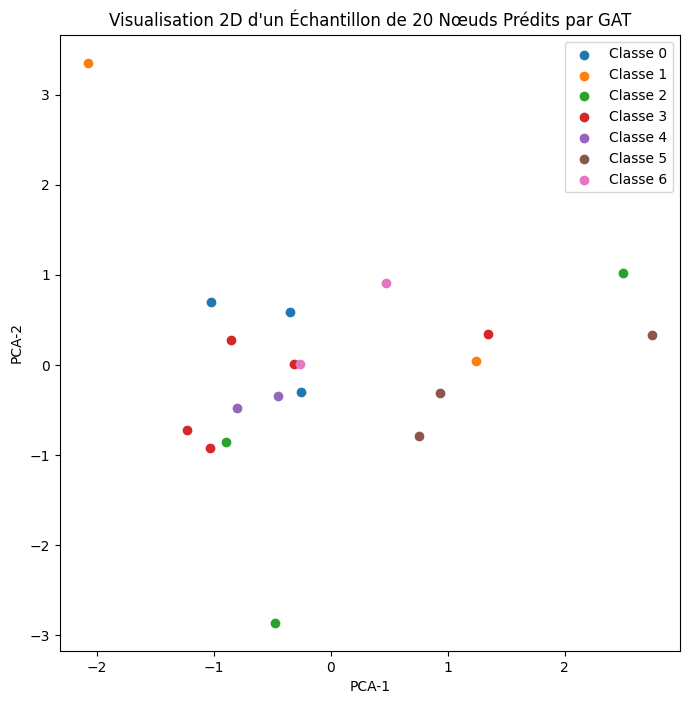

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.decomposition import PCA


# Obtenir les prédictions pour tous les nœuds
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)

# Sélectionner un échantillon aléatoire de 20 nœuds
np.random.seed(0)  # Pour la reproductibilité
sample_indices = np.random.choice(range(data.x.size(0)), 20, replace=False)
sample_predictions = out[sample_indices].max(1)[1]

# Réduire les dimensions à 2D pour la visualisation (en utilisant PCA)
pca = PCA(n_components=2, random_state=0)
node_embeddings_2d = pca.fit_transform(data.x[sample_indices].detach().numpy())

# Tracé
fig, ax = plt.subplots(figsize=(8, 8))

for class_idx in range(dataset.num_classes):
    # Sélectionner les nœuds de la même classe et les tracer
    indices = sample_predictions == class_idx
    ax.scatter(node_embeddings_2d[indices, 0], node_embeddings_2d[indices, 1], label=f'Classe {class_idx}')

ax.legend()
ax.set_title('Visualisation 2D d\'un Échantillon de 20 Nœuds Prédits par GAT')
ax.set_xlabel('PCA-1')
ax.set_ylabel('PCA-2')
plt.show()
